In [1]:
# add parent dir to sys.path so we can import from repo base
import os; import sys; sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from definitions import model_dir
from script.dataset import get_data, cols_emg, cols_emg_cal, SplitDataset
from script.visualization import report_cm

In [3]:
X, y = get_data()

In [4]:
# extract center 100 data points from each set & one-hot encode labels

window_size = 100
data = list()
labels = list()
people = list()

for i, count in X.value_counts('id').items():
    start = int(count / 2 - window_size / 2)
    idx_range = X[X['id'] == i].index[start:start + window_size]
    data.append(np.array(X.iloc[idx_range][cols_emg + cols_emg_cal]))
    labels.append(y[i])
    people.append(i.split('_')[1])
    
data = np.array(data)
data_dim = data.shape
print(f'data shape: {data_dim}')

scaler = StandardScaler()
data = data.reshape(-1, 8)  # reshape to 2D for scaling
data = scaler.fit_transform(data)
data = data.reshape(*data_dim)  # reshape back to original shape

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(np.array(labels).reshape(-1, 1))
print(f'labels shape: {labels.shape}, classes: {encoder.categories_}')

people = pd.Series(people)

data shape: (312, 100, 16)
labels shape: (312, 2), classes: [array(['crimp', 'sloper_jug'], dtype='<U10')]


In [5]:
# train/test split & folds

dataset = SplitDataset(data, labels, people)

In [6]:
# pytorch device & tensors

# use gpu > apple silicon > cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else (torch.device("mps") if torch.backends.mps.is_available() else "cpu"))

def dataset_to_tensors(data, labels):   
    data = torch.tensor(data, dtype=torch.float32, device=device)
    # change dimensions to (batch_size, num_features, seq_length)
    data = data.transpose(1, 2)
    labels = torch.tensor(labels, dtype=torch.float32, device=device)
    return (data, labels)

In [7]:
# network

class CNN(nn.Module):
    def __init__(self, seq_length, kernel_size = 5, num_features = 32, in_channels = 16, classes = 4):
        super(CNN, self).__init__()

        conv_diff = kernel_size - 1
        lin_in = int(((seq_length - conv_diff) / 2 - conv_diff) / 2 * num_features)
        conv1_feats = int(in_channels + (num_features - in_channels) / 2)
        
        self.stack = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=conv1_feats, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=conv1_feats, out_channels=num_features, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(lin_in, classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        i = torch.nn.Identity()
        c = i(x)
        c = self.stack(c)
        return c

model = CNN(window_size, classes=labels.shape[1])
print(f'number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
del model

number of parameters: 7226


In [8]:
# training

def train_epoch(model, optimizer, criterion, dataloader):
    model.train()
    running_loss = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    # epoch loss
    return running_loss / len(dataloader.dataset)

def train(model, optimizer, criterion, data, labels, num_epochs = 20, batch_size=8):
    # data loading
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    best_loss = float('inf')
    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, optimizer, criterion, dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')

In [9]:
models = list()

for fold, (data, labels) in enumerate(dataset.get_train()):
    print(f'Fold {fold + 1}/{dataset.n_folds}')
    
    data_t, labels_t = dataset_to_tensors(data, labels)
    model = CNN(window_size, classes=labels_t.shape[1]).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(model, optimizer, criterion, data_t, labels_t)
    models.append(model)

Fold 1/5
Epoch 1/20, Loss: 0.6054
Epoch 2/20, Loss: 0.4614
Epoch 3/20, Loss: 0.4092
Epoch 4/20, Loss: 0.4043
Epoch 5/20, Loss: 0.3911
Epoch 6/20, Loss: 0.3908
Epoch 7/20, Loss: 0.3694
Epoch 8/20, Loss: 0.3688
Epoch 9/20, Loss: 0.3633
Epoch 10/20, Loss: 0.3595
Epoch 11/20, Loss: 0.3622
Epoch 12/20, Loss: 0.3589
Epoch 13/20, Loss: 0.3778
Epoch 14/20, Loss: 0.3501
Epoch 15/20, Loss: 0.3484
Epoch 16/20, Loss: 0.3441
Epoch 17/20, Loss: 0.3530
Epoch 18/20, Loss: 0.3477
Epoch 19/20, Loss: 0.3430
Epoch 20/20, Loss: 0.3356
Training complete
Fold 2/5
Epoch 1/20, Loss: 0.6122
Epoch 2/20, Loss: 0.4898
Epoch 3/20, Loss: 0.4482
Epoch 4/20, Loss: 0.4109
Epoch 5/20, Loss: 0.4068
Epoch 6/20, Loss: 0.3987
Epoch 7/20, Loss: 0.3805
Epoch 8/20, Loss: 0.3776
Epoch 9/20, Loss: 0.3774
Epoch 10/20, Loss: 0.3958
Epoch 11/20, Loss: 0.3814
Epoch 12/20, Loss: 0.3589
Epoch 13/20, Loss: 0.3793
Epoch 14/20, Loss: 0.3670
Epoch 15/20, Loss: 0.3640
Epoch 16/20, Loss: 0.3543
Epoch 17/20, Loss: 0.3871
Epoch 18/20, Loss: 0

# Model 0

accuracy: 0.975


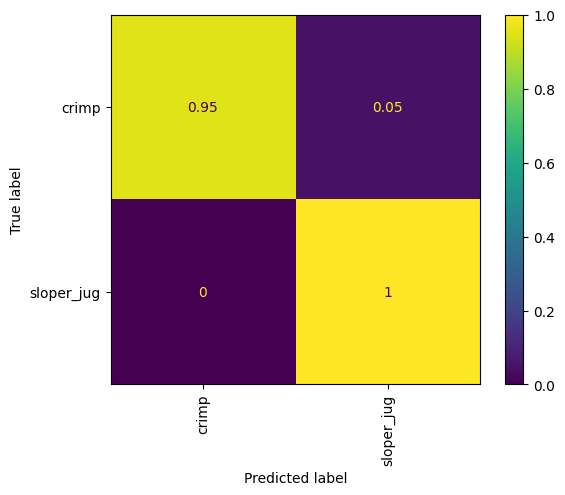

              precision    recall  f1-score   support

       crimp       1.00      0.95      0.97        40
  sloper_jug       0.95      1.00      0.98        40

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80



# Model 1

accuracy: 0.925


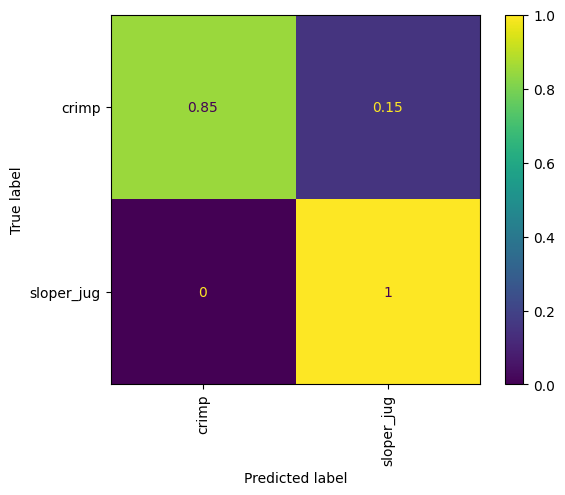

              precision    recall  f1-score   support

       crimp       1.00      0.85      0.92        40
  sloper_jug       0.87      1.00      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



# Model 2

accuracy: 0.9875


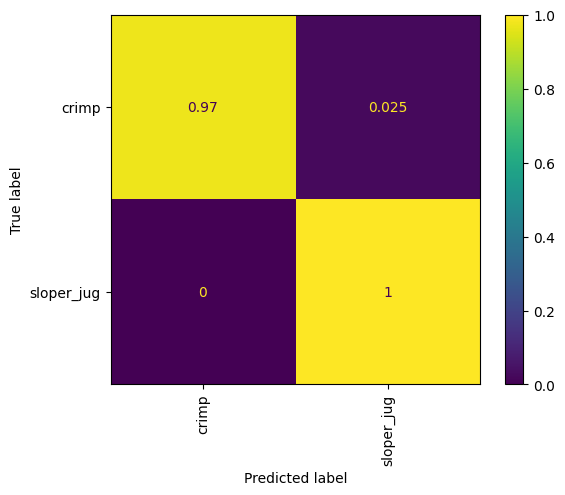

              precision    recall  f1-score   support

       crimp       1.00      0.97      0.99        40
  sloper_jug       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



# Model 3

accuracy: 0.9625


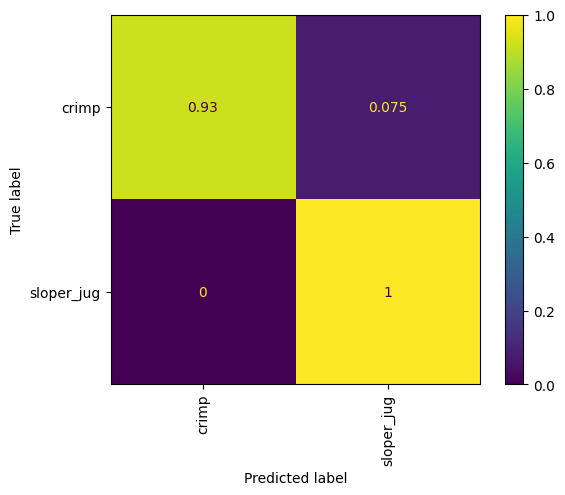

              precision    recall  f1-score   support

       crimp       1.00      0.93      0.96        40
  sloper_jug       0.93      1.00      0.96        40

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



# Model 4

accuracy: 0.925


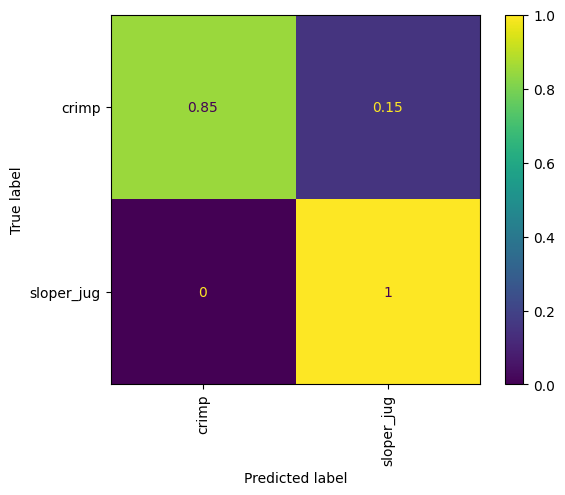

              precision    recall  f1-score   support

       crimp       1.00      0.85      0.92        40
  sloper_jug       0.87      1.00      0.93        40

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.92        80



In [10]:
# load best model
accuracies = list()
for n, model in enumerate(models):
    data, labels = dataset_to_tensors(*dataset.get_test())
    
    model.eval()
    with torch.no_grad():
        outputs = model(data)
        _, prediction = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)
        
    def transform_labels(labels):
        return encoder.categories_[0][np.array(labels.cpu())]
    true, pred = transform_labels(true_labels), transform_labels(prediction)
    
    report_cm(f'Model {n}', true, pred, encoder.categories_[0])
    print(classification_report(true, pred))
    accuracies.append(accuracy_score(true, pred))

pd.Series(accuracies, name='CNN').to_csv(os.path.join(model_dir, 'cnn.csv'))